# Import Libraries

In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [114]:
file_version = 10

In [115]:
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-2,    # 0.02
    'BATCH_SIZE':256,
    'SEED':41
}

In [116]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [117]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
data_info = pd.read_excel("./data/data_info.xlsx")

## 결측치 처리

<AxesSubplot:>

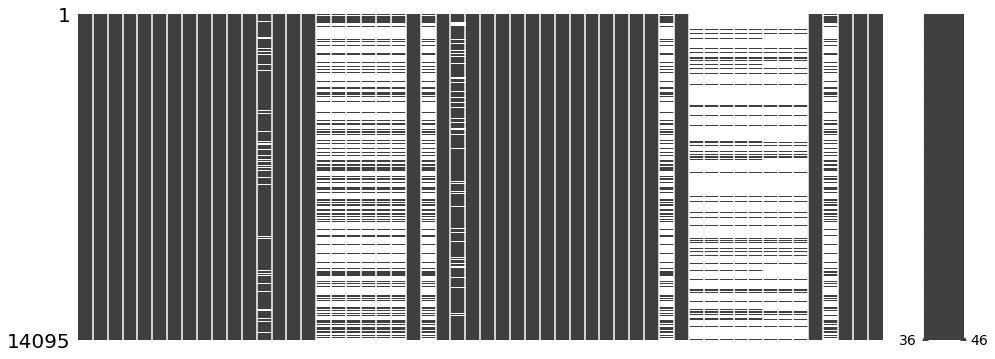

In [118]:
import missingno as msno
msno.matrix(train, figsize=(16,6))

In [119]:
# msno.heatmap(train)

In [120]:
# msno.dendrogram(train)

In [121]:
# train.info()

In [122]:
# 엑셀 파일에서 선택
drop_columns = data_info[data_info["드랍칼럼1"]=="○"]["Feature Name"]
drop_columns = drop_columns.tolist()
drop_columns

['ID',
 'SAMPLE_TRANSFER_DAY',
 'CD',
 'FTBN',
 'H2O',
 'LI',
 'MO',
 'PB',
 'SB',
 'SN',
 'SOOTPERCENTAGE',
 'U50',
 'U25',
 'U20',
 'U14',
 'U6',
 'U4',
 'V100']

In [123]:
train = train.drop(columns = drop_columns, axis = 1)
train.head(2)

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,PQINDEX,S,SI,TI,U100,U75,V,V40,ZN,Y_LABEL
0,COMPONENT3,1486,2011,200,0,3,93,0,0,3059,...,8504,21370,427,5,NaN,NaN,0,154.0,75,0
1,COMPONENT2,1350,2021,375,0,2,19,0,0,2978,...,19,1117,0,0,0.0,0.0,0,44.0,652,0


In [124]:
len(test.columns)

19

In [125]:
for col in drop_columns:
    if col in test.columns:
        test.drop(columns = col, axis = 1, inplace = True)
    else:
        pass
print(len(test.columns))

16


In [126]:
# train.info()

In [127]:
# msno.matrix(train)

In [128]:
train.describe(include="all")

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,PQINDEX,S,SI,TI,U100,U75,V,V40,ZN,Y_LABEL
count,14095,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,...,14095.000000,14095.000000,14095.000000,14095.000000,2316.000000,2316.000000,14095.000000,14095.000000,14095.000000,14095.000000
unique,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,COMPONENT3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,7050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3146.082937,2013.652501,387.416885,0.025825,12.707698,64.026179,0.692799,0.006314,1366.757574,...,415.159631,12029.318624,35.058248,0.707911,0.173575,0.417098,0.050656,109.355815,588.646825,0.085349
std,NaN,4216.089809,3.964758,550.016073,0.171926,86.968000,102.876871,2.905491,0.152189,1481.924727,...,1528.191012,9325.610196,195.329029,6.897579,0.878892,1.626333,0.475438,49.612379,531.743393,0.279411
min,NaN,1000.000000,2007.000000,200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,386.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.900000,0.000000,0.000000
25%,NaN,1655.000000,2010.000000,200.000000,0.000000,1.000000,3.000000,0.000000,0.000000,48.000000,...,12.000000,4440.500000,3.000000,0.000000,0.000000,0.000000,0.000000,71.800000,37.000000,0.000000
50%,NaN,2227.000000,2014.000000,200.000000,0.000000,2.000000,11.000000,0.000000,0.000000,198.000000,...,29.000000,8034.000000,6.000000,0.000000,0.000000,0.000000,0.000000,111.300000,520.000000,0.000000
75%,NaN,3797.000000,2017.000000,410.000000,0.000000,4.000000,110.000000,0.000000,0.000000,2975.000000,...,181.000000,19750.000000,12.000000,0.000000,0.000000,0.000000,0.000000,137.200000,1119.000000,0.000000


In [129]:
# 널값 칼럼값을 무엇으로 보간할까?
null_columns = []
for col in train.columns.tolist():
    if train[col].isna().any():
        null_columns.append(col)
        print(f"컬럼명: {col}, 널값수: {train[col].isna().sum()}, 평균: {train[col].mean()}, 중위수: {train[col].median()}, 최빈값: {train[col].mode().values[0]}")
    else:
        pass   
# null_columns

컬럼명: FH2O, 널값수: 10205, 평균: 15.24215938303342, 중위수: 13.0, 최빈값: 14.0
컬럼명: FNOX, 널값수: 10205, 평균: 7.138303341902313, 중위수: 7.0, 최빈값: 6.0
컬럼명: FOPTIMETHGLY, 널값수: 10205, 평균: 0.532904884318766, 중위수: 0.0, 최빈값: 0.0
컬럼명: FOXID, 널값수: 10205, 평균: 12.495372750642673, 중위수: 12.0, 최빈값: 11.0
컬럼명: FSO4, 널값수: 10205, 평균: 20.28431876606684, 중위수: 20.0, 최빈값: 20.0
컬럼명: FUEL, 널값수: 10205, 평균: 0.1853470437017995, 중위수: 0.0, 최빈값: 0.0
컬럼명: K, 널값수: 2299, 평균: 3.6112241437775516, 중위수: 2.0, 최빈값: 0.0
컬럼명: U100, 널값수: 11779, 평균: 0.17357512953367876, 중위수: 0.0, 최빈값: 0.0
컬럼명: U75, 널값수: 11779, 평균: 0.4170984455958549, 중위수: 0.0, 최빈값: 0.0


In [130]:
train[null_columns].describe(include="all")

,FH2O,FNOX,FOPTIMETHGLY,FOXID,FSO4,FUEL,K,U100,U75
count,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,11796.000000,2316.000000,2316.000000
mean,15.242159,7.138303,0.532905,12.495373,20.284319,0.185347,3.611224,0.173575,0.417098
std,17.591679,1.860775,0.621937,3.439535,3.234296,0.899253,15.630404,0.878892,1.626333
min,6.000000,3.000000,0.000000,4.000000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,6.000000,0.000000,10.000000,18.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,7.000000,0.000000,12.000000,20.000000,0.000000,2.000000,0.000000,0.000000
75%,15.000000,8.000000,1.000000,14.750000,22.000000,0.000000,3.000000,0.000000,0.000000
max,320.000000,38.000000,13.000000,68.000000,68.000000,12.000000,705.000000,18.000000,33.000000


In [131]:
# for col in train.columns.tolist():
#     if train[col].isna().any():
#         print(f"중위수: {train[col].median()}, \n값빈도:\n{train[col].value_counts()[:]}")
#         print("-"*15)
#     else:
#         pass   

In [132]:
# nan 보간 : 평균 or 중위수 or 최빈값
for col in null_columns:
    보간값 = train[col].mode().values[0] # 최빈값
    print(보간값)
    train[col] = train[col].fillna(보간값)     

14.0
6.0
0.0
11.0
20.0
0.0
0.0
0.0
0.0


In [133]:
# msno.matrix(train)

In [134]:
all_X = train.drop(['Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']

# test = test.drop(['ID'], axis = 1)

train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)

In [135]:
train_X.head(2)

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,P,PQINDEX,S,SI,TI,U100,U75,V,V40,ZN
822,COMPONENT3,3207,2011,200,0,2,45,0,0,42,...,162,245,12720,1,0,0.0,0.0,0,144.1,6
6794,COMPONENT2,5958,2013,200,0,0,0,0,0,45,...,495,70,3931,4,0,0.0,0.0,0,47.6,545


In [136]:
val_X.head(2)

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,P,PQINDEX,S,SI,TI,U100,U75,V,V40,ZN
1075,COMPONENT3,2453,2013,200,0,2,19,0,0,134,...,1091,238,3613,10,0,0.0,0.0,0,57.7,1354
4,COMPONENT3,3954,2015,200,0,1,157,0,0,71,...,309,217,18470,2,0,0.0,0.0,0,133.1,128


In [137]:
categorical_features = ['COMPONENT_ARBITRARY', 'YEAR']

In [138]:
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_X.columns:
    if col not in categorical_features:   # 범주형 칼럼이 아니라면 표준화
        scaler = StandardScaler()
        train_X[col] = scaler.fit_transform(get_values(train_X[col]))
        val_X[col] = scaler.transform(get_values(val_X[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
            


#### OneHotEncoding

In [139]:

train_ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first', sparse=False), [0, 2])], remainder='passthrough')
train_X = train_ct.fit_transform(train_X)
train_X = pd.DataFrame(train_X)
new_name1 = train_ct.get_feature_names()
train_X.columns = new_name1

val_ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first', sparse=False), [0, 2])], remainder='passthrough')
val_X = val_ct.fit_transform(val_X)
val_X = pd.DataFrame(val_X)
new_name2 = val_ct.get_feature_names()
val_X.columns = new_name2

test_ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first', sparse=False), [0, 2])], remainder='passthrough')
test = test_ct.fit_transform(test)
test = pd.DataFrame(test)
new_name3 = test_ct.get_feature_names()
test.columns = new_name3


In [140]:
test_stage_features = new_name3
# Inference(실제 진단 환경)에 사용하는 컬럼
test_stage_features

['encoder__x0_COMPONENT2',
 'encoder__x0_COMPONENT3',
 'encoder__x0_COMPONENT4',
 'encoder__x1_2008',
 'encoder__x1_2009',
 'encoder__x1_2010',
 'encoder__x1_2011',
 'encoder__x1_2012',
 'encoder__x1_2013',
 'encoder__x1_2014',
 'encoder__x1_2015',
 'encoder__x1_2016',
 'encoder__x1_2017',
 'encoder__x1_2018',
 'encoder__x1_2019',
 'encoder__x1_2020',
 'encoder__x1_2021',
 'encoder__x1_2022',
 'ANONYMOUS_1',
 'ANONYMOUS_2',
 'AG',
 'CO',
 'CR',
 'CU',
 'FE',
 'MN',
 'NI',
 'PQINDEX',
 'TI',
 'V',
 'V40',
 'ZN']

In [141]:
train_col_num = len(train_X.columns)
test_col_num = len(test.columns)
print(train_col_num, test_col_num) # Drop후 칼럼 갯수 (nn 시작 노드 갯수에 맞춰주기 위해 변수에 담아놓음)

51 32


In [142]:
import pickle

#저장하기
with open(f"./data/refined_train_X{file_version}", 'wb') as pickle_filename:
	pickle.dump(train_X, pickle_filename)

with open(f"./data/refined_train_y{file_version}", 'wb') as pickle_filename:
	pickle.dump(train_y, pickle_filename)
    
with open(f"./data/refined_val_X{file_version}", 'wb') as pickle_filename:
	pickle.dump(val_X, pickle_filename)

with open(f"./data/refined_val_y{file_version}", 'wb') as pickle_filename:
	pickle.dump(val_y, pickle_filename)
    
with open(f"./data/refined_test{file_version}", 'wb') as pickle_filename:
	pickle.dump(test, pickle_filename)

In [143]:
#불러오기
with open(f"./data/refined_train_X{file_version}", 'rb') as pickle_filename:
	train_X = pickle.load(pickle_filename)

with open(f"./data/refined_train_y{file_version}", 'rb') as pickle_filename:
	train_y = pickle.load(pickle_filename)
    
with open(f"./data/refined_val_X{file_version}", 'rb') as pickle_filename:
	val_X = pickle.load(pickle_filename)

with open(f"./data/refined_val_y{file_version}", 'rb') as pickle_filename:
	val_y = pickle.load(pickle_filename)     

with open(f"./data/refined_test{file_version}", 'rb') as pickle_filename:
	test = pickle.load(pickle_filename)

In [144]:
class CustomDataset(Dataset):
    def __init__(self, data_X, data_y, distillation=False):
        super(CustomDataset, self).__init__()
        self.data_X = data_X
        self.data_y = data_y
        self.distillation = distillation
        
    def __len__(self):
        return len(self.data_X)
    
    def __getitem__(self, index):
        if self.distillation:
            # 지식 증류 학습 시
            teacher_X = torch.Tensor(self.data_X.iloc[index])
            student_X = torch.Tensor(self.data_X[test_stage_features].iloc[index])
            y = self.data_y.values[index]
            return teacher_X, student_X, y
        else:
            if self.data_y is None:
                test_X = torch.Tensor(self.data_X.iloc[index])
                return test_X
            else:
                teacher_X = torch.Tensor(self.data_X.iloc[index])
                y = self.data_y.values[index]
                return teacher_X, y

In [145]:
train_dataset = CustomDataset(train_X, train_y, False)
val_dataset = CustomDataset(val_X, val_y, False)

In [146]:
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [147]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=train_col_num, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [148]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)

    best_score = 0
    best_model = None
    criterion = nn.BCELoss().to(device)

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
  
        model.train()
        for X, y in tqdm(train_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(X)
            
            loss = criterion(y_pred, y.reshape(-1, 1))
            loss.backward()
            
            optimizer.step()

            train_loss.append(loss.item())

        val_loss, val_score = validation_teacher(model, val_loader, criterion, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = model
            best_score = val_score
        
    return best_model 

In [149]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation_teacher(model, val_loader, criterion, device):
    model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(X.to(device))
            
            loss = criterion(model_pred, y.reshape(-1, 1))
            val_loss.append(loss.item())      
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1   

In [150]:
model = Teacher()
model.eval()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

teacher_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.23105] Val Loss : [0.31267] Val F1 Score : [0.80029]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.17614] Val Loss : [0.29052] Val F1 Score : [0.79736]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.17663] Val Loss : [0.27839] Val F1 Score : [0.79515]
Epoch 00003: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.17431] Val Loss : [0.25298] Val F1 Score : [0.80813]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.17281] Val Loss : [0.25919] Val F1 Score : [0.81001]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.17904] Val Loss : [0.25936] Val F1 Score : [0.80440]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.17215] Val Loss : [0.26896] Val F1 Score : [0.80999]
Epoch 00007: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.17071] Val Loss : [0.28444] Val F1 Score : [0.80001]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.17331] Val Loss : [0.26510] Val F1 Score : [0.80426]
Epoch 00009: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.15467] Val Loss : [0.25508] Val F1 Score : [0.80717]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.15336] Val Loss : [0.25813] Val F1 Score : [0.80620]
Epoch 00011: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.15652] Val Loss : [0.25026] Val F1 Score : [0.80621]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.14700] Val Loss : [0.25567] Val F1 Score : [0.80625]
Epoch 00013: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.14680] Val Loss : [0.26010] Val F1 Score : [0.80718]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.14535] Val Loss : [0.25756] Val F1 Score : [0.80621]
Epoch 00015: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.14534] Val Loss : [0.25932] Val F1 Score : [0.80530]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.14367] Val Loss : [0.26111] Val F1 Score : [0.80620]
Epoch 00017: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.14753] Val Loss : [0.25854] Val F1 Score : [0.80244]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.14618] Val Loss : [0.25544] Val F1 Score : [0.80528]
Epoch 00019: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.14521] Val Loss : [0.25798] Val F1 Score : [0.80331]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.14914] Val Loss : [0.25636] Val F1 Score : [0.80331]
Epoch 00021: reducing learning rate of group 0 to 1.9531e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.16295] Val Loss : [0.25287] Val F1 Score : [0.80432]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.14408] Val Loss : [0.25300] Val F1 Score : [0.80063]
Epoch 00023: reducing learning rate of group 0 to 9.7656e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.15498] Val Loss : [0.25742] Val F1 Score : [0.80063]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.15026] Val Loss : [0.25439] Val F1 Score : [0.80151]
Epoch 00025: reducing learning rate of group 0 to 4.8828e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.14480] Val Loss : [0.25907] Val F1 Score : [0.80522]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.14894] Val Loss : [0.25324] Val F1 Score : [0.79965]
Epoch 00027: reducing learning rate of group 0 to 2.4414e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.14459] Val Loss : [0.25605] Val F1 Score : [0.80426]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.15502] Val Loss : [0.25401] Val F1 Score : [0.80623]
Epoch 00029: reducing learning rate of group 0 to 1.2207e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.14465] Val Loss : [0.25689] Val F1 Score : [0.80429]


In [151]:
PATH = f"./models/teacher_net{file_version}.pth"
torch.save(teacher_model.state_dict(), PATH)

In [152]:
teacher_model = Teacher()
teacher_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [153]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=test_col_num, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [154]:
def distillation(student_logits, labels, teacher_logits, alpha):
    distillation_loss = nn.BCELoss()(student_logits, teacher_logits)
    student_loss = nn.BCELoss()(student_logits, labels.reshape(-1, 1))
    return alpha * student_loss + (1-alpha) * distillation_loss

In [155]:
def distill_loss(output, target, teacher_output, loss_fn=distillation, opt=optimizer):
    loss_b = loss_fn(output, target, teacher_output, alpha=0.1)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item()

In [156]:
def student_train(s_model, t_model, optimizer, train_loader, val_loader, scheduler, device):
    s_model.to(device)
    t_model.to(device)
    
    best_score = 0
    best_model = None

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
        s_model.train()
        t_model.eval()
        
        for X_t, X_s, y in tqdm(train_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()

            output = s_model(X_s)
            with torch.no_grad():
                teacher_output = t_model(X_t)
                
            loss_b = distill_loss(output, y, teacher_output, loss_fn=distillation, opt=optimizer)

            train_loss.append(loss_b)

        val_loss, val_score = validation_student(s_model, t_model, val_loader, distill_loss, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = s_model
            best_score = val_score
        
    return best_model

In [157]:
def validation_student(s_model, t_model, val_loader, criterion, device):
    s_model.eval()
    t_model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X_t, X_s, y in tqdm(val_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = s_model(X_s)
            teacher_output = t_model(X_t)
            
            loss_b = distill_loss(model_pred, y, teacher_output, loss_fn=distillation, opt=None)
            val_loss.append(loss_b)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1    

In [158]:
train_dataset = CustomDataset(train_X, train_y, True)
val_dataset = CustomDataset(val_X, val_y, True)

train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [159]:
student_model = Student()
student_model.eval()
optimizer = torch.optim.Adam(student_model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

best_student_model = student_train(student_model, teacher_model, optimizer, train_loader, val_loader, scheduler, device)


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.32741] Val Loss : [0.28905] Val F1 Score : [0.47699]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.28764] Val Loss : [0.28923] Val F1 Score : [0.47767]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.28037] Val Loss : [0.28800] Val F1 Score : [0.47690]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.28199] Val Loss : [0.28653] Val F1 Score : [0.47680]
Epoch 00004: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.28867] Val Loss : [0.28491] Val F1 Score : [0.48178]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.27753] Val Loss : [0.28372] Val F1 Score : [0.47738]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.28160] Val Loss : [0.28552] Val F1 Score : [0.49274]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.27764] Val Loss : [0.28424] Val F1 Score : [0.48189]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.27408] Val Loss : [0.28514] Val F1 Score : [0.49403]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.28116] Val Loss : [0.28432] Val F1 Score : [0.48595]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.27678] Val Loss : [0.28679] Val F1 Score : [0.48595]
Epoch 00011: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.27316] Val Loss : [0.28273] Val F1 Score : [0.49023]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.27759] Val Loss : [0.28477] Val F1 Score : [0.49370]
Epoch 00013: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.26884] Val Loss : [0.28504] Val F1 Score : [0.49738]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.26803] Val Loss : [0.28452] Val F1 Score : [0.49633]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.26622] Val Loss : [0.28832] Val F1 Score : [0.50002]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.27164] Val Loss : [0.28559] Val F1 Score : [0.48907]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.26740] Val Loss : [0.28278] Val F1 Score : [0.49791]
Epoch 00018: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.26773] Val Loss : [0.28487] Val F1 Score : [0.50405]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.26536] Val Loss : [0.28365] Val F1 Score : [0.49370]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.26639] Val Loss : [0.28723] Val F1 Score : [0.50345]
Epoch 00021: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.26448] Val Loss : [0.28646] Val F1 Score : [0.49633]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.26369] Val Loss : [0.28570] Val F1 Score : [0.49274]
Epoch 00023: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.26345] Val Loss : [0.28574] Val F1 Score : [0.49685]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.26682] Val Loss : [0.28739] Val F1 Score : [0.49599]
Epoch 00025: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.26652] Val Loss : [0.28602] Val F1 Score : [0.50660]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.26378] Val Loss : [0.28536] Val F1 Score : [0.50002]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.26633] Val Loss : [0.28503] Val F1 Score : [0.49685]
Epoch 00028: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.26429] Val Loss : [0.28432] Val F1 Score : [0.49599]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.26516] Val Loss : [0.28402] Val F1 Score : [0.49290]
Epoch 00030: reducing learning rate of group 0 to 1.9531e-05.


In [160]:
PATH1 = f"./models/student_net{file_version}.pth"
torch.save(best_student_model.state_dict(), PATH1)

In [161]:
best_student_model = Student()
best_student_model.load_state_dict(torch.load(PATH1))

<All keys matched successfully>

In [162]:
def choose_threshold(model, val_loader, device):
    model.to(device)
    model.eval()
    
    thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    pred_labels = []
    true_labels = []
    
    best_score = 0
    best_thr = None
    with torch.no_grad():
        for _, x_s, y in tqdm(iter(val_loader)):
            x_s = x_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(x_s)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        for threshold in thresholds:
            pred_labels_thr = np.where(np.array(pred_labels) > threshold, 1, 0)
            score_thr = competition_metric(true_labels, pred_labels_thr)
            if best_score < score_thr:
                best_score = score_thr
                best_thr = threshold
    return best_thr, best_score

In [163]:
best_threshold, best_score = choose_threshold(best_student_model, val_loader, device)
print(f'Best Threshold : [{best_threshold}], Score : [{best_score:.5f}]')

  0%|          | 0/12 [00:00<?, ?it/s]

Best Threshold : [0.2], Score : [0.52190]


In [164]:
test_datasets = CustomDataset(test, None, False)
test_loaders = DataLoader(test_datasets, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [165]:
def inference(model, test_loader, threshold, device):
    model.to(device)
    model.eval()
    
    test_predict = []
    with torch.no_grad():
        for x in tqdm(test_loader):
            x = x.float().to(device)
            model_pred = model(x)

            model_pred = model_pred.squeeze(1).to('cpu')
            test_predict += model_pred
        
    test_predict = np.where(np.array(test_predict) > threshold, 1, 0)
    print('Done.')
    return test_predict

In [166]:
preds = inference(best_student_model, test_loaders, best_threshold, device)

  0%|          | 0/24 [00:00<?, ?it/s]

Done.


In [167]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['Y_LABEL'] = preds
submit.head()

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


In [168]:
submit.to_csv(f'./submits/submit{file_version}.csv', index=False)